In [116]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from numba import jit

In [273]:
x_dim = 2 # dimension of observations
num_clusters = 10
mus = []

sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T

for i in range(num_clusters):
    mus.append(50*np.random.randn(x_dim,1))
    
per_class_sample = 10000 # number of data points
samples = per_class_sample * num_clusters

In [274]:
classes = []
for i in range(num_clusters):
    classes.append(mus[i] + np.random.randn(x_dim,int(per_class_sample)))

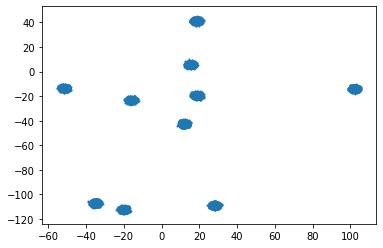

In [275]:
X = np.concatenate(classes, axis=1)
plt.scatter(X[0],X[1],s=1)
plt.show()

In [276]:
Z = np.zeros((2,samples))
Z[0, per_class_sample:] = 1
Z[1, 0:per_class_sample] = 1

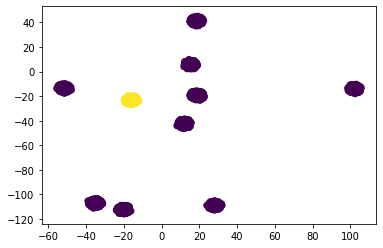

In [277]:
X = np.concatenate(classes, axis=1)
plt.scatter(X[0],X[1],c=Z[1])
plt.show()

## Hard Clustering

In [278]:
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .01
rho = .5
#idx = np.random.permutation(samples)

#s = np.empty(idx.size, dtype=np.int32)
#for i in np.arange(idx.size):
#    s[idx[i]] = i
    
    
#X = X[:, idx]
#Z = Z[:, idx]
neural = False

def cluster(x, W, theta, n):
    #Initializing Variables

    

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = np.zeros(1)

    if neural: ## Neural Step 3

        er  = 1
        itr = 1

        # Iterate until convergence
        while er > 1e-7:

            z_prev = z
            y_prev = y

        
            
            # Update y and z
            y = np.maximum( 0, y + (eta)*( -a - z - rho*(np.sum(y, axis=0) - 1) ) );
            z += eta*( np.sum(y, axis=0) - 1 )
            

            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1

    else: ## Non=Neural Step 3
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]

    #Step 4

    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/n[i]

        theta[i] += y[i]*(z - theta[i])/n[i]

    for j in range(num_clusters):
        Y[j,t] = y[j]
    

for t in tqdm(range(samples)):
    x = X[:,t].reshape((x_dim,1))
    cluster(x, W, theta, n)

for i in range(num_clusters):
    print(f'Cluster {i+1} mean: {W[i,:]/2}')

100%|██████████| 100000/100000 [00:17<00:00, 5589.72it/s]

Cluster 1 mean: [15.34734058  5.53086399]
Cluster 2 mean: [-51.52591668 -13.52453625]
Cluster 3 mean: [-0.09616468  0.13961285]
Cluster 4 mean: [ 18.67342086 -19.41547491]
Cluster 5 mean: [-23.71221562 -80.76967924]
Cluster 6 mean: [-0.3172748   0.01439446]
Cluster 7 mean: [60.38507318 13.5834814 ]
Cluster 8 mean: [-0.11675002  0.08173277]
Cluster 9 mean: [-0.03698479 -0.21257909]
Cluster 10 mean: [ 20.07332545 -75.68187597]


In [279]:
e = np.zeros((num_clusters, num_clusters))
for i in range(num_clusters):
    e[i,i] = 1

In [280]:
mu_1 = np.sum([e[i]*per_class_sample for i in range(1,num_clusters)], axis=0)/((num_clusters-1)*per_class_sample)
mu_2 = e[0]
Sigma = np.eye(num_clusters)

In [281]:
w_opt = np.linalg.inv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)

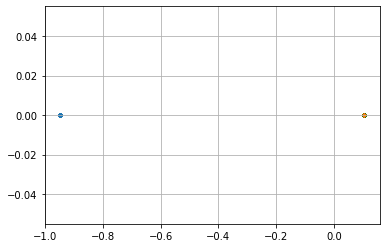

In [282]:
plt.scatter(w_opt.T@Y[:,per_class_sample:],np.zeros((w_opt.T@Y[:,per_class_sample:]).shape),s=5)
plt.scatter(w_opt.T@Y[:,:per_class_sample],np.zeros((w_opt.T@Y[:,:per_class_sample]).shape),s=5)
plt.grid()
plt.show()

In [283]:
@jit(nopython=True)
def eta(t):
    return 1e-4/(1+1e-4*t)

gam = 100; epochs = 20; iters = epochs*samples

In [284]:
@jit(nopython=True)
def fit_sparse(w, l, mu, b, x, y, t):
    z = w.T@x

    b = max(b + (y[1]-b)/t,1e-5)

    mu += (x - mu)/t
    nu = w.T@mu

    step = eta(t)

    w += step*(x - l*(z-nu)*(x-mu)) - step*y[1]*x/b
    l += gam*step*((z-nu)**2 - 1)
    
    return w, l, mu, b, x, y

def run_sparse(X, Y):
    
    w = np.random.randn(num_clusters)/np.sqrt(num_clusters)
    l = 1
    
    mu = np.zeros(num_clusters)

    b = 0.5

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]
            


            w, l, mu, b, x, y = fit_sparse(w, l, mu, b, x, y, t)
            
            
        
        #print(f'Error: {err_approx[i_iter]}')
    return w


w = run_sparse(Y,Z)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-284-8dc35b573382>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  z = w.T@x
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
<ipython-input-284-8dc35b573382>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  z = w.T@x
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
100%|██████████| 20/20 [00:05<00:00,  4.30it/s]


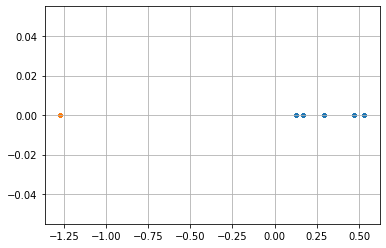

In [285]:
#Y_ = Y[:, s]

plt.scatter(w.T@Y[:,per_class_sample:],np.zeros((w.T@Y[:,per_class_sample:]).shape),s=10)
plt.scatter(w.T@Y[:,0:per_class_sample],np.zeros((w.T@Y[:,0:per_class_sample]).shape),s=10)

plt.grid()
plt.show()

## Soft Clustering

In [18]:
num_clusters = 2
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .1
rho = 5
idx = np.random.permutation(samples)
neural = True
alpha = 10**-2.5
for t in tqdm(range(samples)):
    
    #Initializing Variables
    x = X[:,idx[t]].reshape((x_dim,1))

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = 0

    if neural: ## Neural Step 3
        
        er  = 1
        itr = 1
        
        # Iterate until convergence
        while er > 1e-7:
        
            z_prev = z
            y_prev = y
            
            # Update y and z
            
            y = np.maximum( 0, y + (eta)*(-alpha*t*y/n -a - z - rho*(np.sum(y) - 1)) );
            z += eta*(np.sum(y) - 1) - 1
            
            
            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1
        
    else: ## Non-Neural Step 3
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]
    
    ## Step 4
    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/n[i]

        theta[i] += y[i]*(z - theta[i])/n[i]

    for j in range(num_clusters):
        Y[j,idx[t]] = y[j]

for i in range(num_clusters):
    print(f'Cluster {i+1} mean: {W[i,:]/num_clusters}')

100%|██████████| 1000/1000 [01:13<00:00, 10.85it/s]

Cluster 1 mean: [10.0270086  -0.03370123]
Cluster 2 mean: [-5.59314843e-03  9.92398284e+00]
